In [1]:
import os
import time
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
data = pd.read_csv('selected_data.csv')
data['GDatetime'] = pd.to_datetime(data['GDatetime'])
data.set_index('GDatetime', inplace=True)
data

,F_RunState,F_CycleTime,F_SpindleRPM1,F_SpindleTroq1,F_SpindleGearRatio1,F_ToolNum,G_ADC1,G_ADC2,G_ADC3,G_MV,G_MA,G_MActP,G_MFeq,G_MTemp,label,anomaly
GDatetime,,,,,,,,,,,,,,,,
2023-06-05 07:03:45,2.0,0.0,0.0,0.0,0.0,0.0,24.400000,43.700001,0.0,222.020004,2.974,0.924,59.970001,39.0,0,0
2023-06-05 07:03:46,2.0,0.0,0.0,0.0,0.0,0.0,24.400000,43.700001,0.0,221.529999,2.976,0.924,59.970001,39.0,0,0
2023-06-05 07:03:47,2.0,0.0,0.0,0.0,0.0,0.0,24.400000,43.700001,0.0,221.529999,2.976,0.924,59.970001,39.0,0,0
2023-06-05 07:03:48,2.0,0.0,0.0,0.0,0.0,0.0,24.400000,43.700001,0.0,220.729996,2.976,0.920,59.959999,39.0,0,0
2023-06-05 07:03:49,2.0,0.0,0.0,0.0,0.0,0.0,24.299999,43.700001,0.0,221.630005,2.962,0.920,59.959999,39.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-01 16:27:16,2.0,10424.0,0.0,0.0,712.0,21.0,37.200001,38.900002,0.0,220.570007,11.092,2.656,59.970001,45.0,363,0
2023-07-01 16:27:17,2.0,10424.0,0.0,0.0,712.0,21.0,37.200001,38.900002,0.0,220.669998,11.046,2.644,59.970001,45.0,363,0
2023-07-01 16:27:18,2.0,10424.0,0.0,0.0,712.0,21.0,37.200001,38.900002,0.0,220.669998,11.046,2.644,59.970001,45.0,363,0


In [3]:
def find_cycle_periods(data, threshold_low=100, threshold_high=10000, sub_cycle_threshold=1000, sub_cycle_length_minutes=50):
    cycle_starts = []
    cycle_ends = []
    in_cycle = False
    in_high = False
    in_sub_cycle = False
    label = -1 # 주기 라벨 (0부터 시작)
    
    # label 열을 추가하고 -1로 초기화
    data['label'] = 0
    sub_cycle_start_time = None
    sub_cycle_length = 0
    
    for i in range(len(data) - 1):
        value = data['F_CycleTime'].iloc[i]
        next_value = data['F_CycleTime'].iloc[i + 1]
        
        # 주기 시작 지점 찾기 (0 ~ 100 근처에서 올라가기 시작)
        if not in_cycle and value <= threshold_low:
            in_cycle = True
            label += 1 # 새로운 주기 시작, 라벨 증가
            cycle_starts.append(data.index[i]) # datetime 인덱스 사용
        
        # 주기 내부라면 현재 라벨로 표시
        if in_cycle:
            data['label'].iloc[i] = label

        # 1만 근처의 값에 도달
        if in_cycle and not in_high and value >= threshold_high:
            in_high = True

        # 1천 근처의 값에 도달
        if in_cycle and not in_high and value >= sub_cycle_threshold:
            in_sub_cycle = True
            if sub_cycle_start_time is None:
                sub_cycle_start_time = data.index[i]

        # 하위 주기의 끝 지점 찾기
        if in_sub_cycle and next_value <= threshold_low:
            sub_cycle_length += (data.index[i] - sub_cycle_start_time).seconds / 60
            sub_cycle_start_time = None
            if sub_cycle_length >= sub_cycle_length_minutes:
                in_high = True
            in_sub_cycle = False
            
        # 주기 끝 지점 찾기
        if in_high and next_value <= threshold_low:
            in_high = False
            in_cycle = False
            cycle_ends.append(data.index[i]) # datetime 인덱스 사용
            sub_cycle_length = 0
            
    # 마지막 주기의 끝 지점 처리
    if in_cycle:
        cycle_ends.append(data.index[-1])

    return cycle_starts, cycle_ends


def remove_constant_values(data, lower_bound=1000, upper_bound=12000, duration_minutes=20):
    constant_value = None
    constant_start_time = None
    rows_to_drop = []

    for i in range(len(data) - 1):
        value = data['F_CycleTime'].iloc[i]

        # 값이 범위 내에 있고 이전 값과 동일한 경우
        if lower_bound <= value < upper_bound and value == constant_value:
            if constant_start_time is None:
                constant_start_time = data.index[i]
            # 지속 시간이 20분 이상인 경우
            if (data.index[i] - constant_start_time).seconds / 60 >= duration_minutes:
                rows_to_drop.append(data.index[i])
        else:
            constant_value = value
            constant_start_time = None

    # 행 삭제
    data.drop(rows_to_drop, inplace=True)
    return data



selected_data = data

selected_data = remove_constant_values(selected_data)

# 중복된 인덱스를 가진 행의 평균값으로 병합
selected_data = selected_data.groupby(selected_data.index).mean()

cycle_starts, cycle_ends = find_cycle_periods(selected_data)

selected_data = selected_data.iloc[:-1]
selected_data['anomaly'] = 0
specific_labels = [43, 188, 243, 256, 258, 270, 291, 295, 325, 340, 349, 360]
selected_data.loc[selected_data['label'].isin(specific_labels), 'anomaly'] = 1

In [136]:
# 최대 샘플 길이를 정의 (선택적)
max_length = max(len(selected_data.loc[start:end]) for start, end in zip(cycle_starts, cycle_ends))

def create_3d_array(data, cycle_starts, cycle_ends, max_length=None, 
                    feature_columns=['F_RunState', 'F_ToolNum', 'F_CycleTime', 'F_SpindleRPM1', 'F_SpindleTroq1', 'G_ADC1', 'G_ADC2', 'G_ADC3', 'G_MV', 'G_MActP', 'G_MTemp', 'anomaly']):
    # 주기별 샘플을 저장할 리스트
    samples = []

    # 각 주기를 샘플로 변환
    for start, end in zip(cycle_starts, cycle_ends):
        sample = data.loc[start:end][feature_columns].values
        
        # 샘플 길이 통일 (선택적)
        if max_length:
            if len(sample) > max_length:
                sample = sample[:max_length]
            elif len(sample) < max_length:
                padding = np.zeros((max_length - len(sample), len(feature_columns)))
                sample = np.vstack((sample, padding))
        
        samples.append(sample)

    # 샘플들을 3차원 배열로 쌓기
    samples_array = np.stack(samples)
    
    return samples_array

# 3차원 배열 생성
samples_array = create_3d_array(selected_data, cycle_starts, cycle_ends, max_length=max_length)

# 결과의 형태 출력
X = samples_array[:,:,:-1]
y = samples_array[:,0,-1]
X.shape, y.shape


((364, 7005, 11), (364,))

In [75]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

std = StandardScaler()
mm = MinMaxScaler()

X_train_val = X[:280]
y_train_val = y[:280]
X_test = X[280:]
y_test = y[280:]

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.3, stratify=y_train_val, random_state=42)


# 초기화
X_train_sc = []
X_val_sc = []
X_test_sc = []

# 학습 데이터 변환
for sample in X_train:
    mm_sample = mm.fit_transform(sample[:, :2])
    std_sample = std.fit_transform(sample[:, 2:])
    sc_sample = np.concatenate((mm_sample, std_sample), axis=1)
    X_train_sc.append(sc_sample)

# 검증 데이터 변환
for sample in X_val:
    mm_sample = mm.transform(sample[:, :2])
    std_sample = std.transform(sample[:, 2:])
    sc_sample = np.concatenate((mm_sample, std_sample), axis=1)
    X_val_sc.append(sc_sample)

# 테스트 데이터 변환
for sample in X_test:
    mm_sample = mm.transform(sample[:, :2])
    std_sample = std.transform(sample[:, 2:])
    sc_sample = np.concatenate((mm_sample, std_sample), axis=1)
    X_test_sc.append(sc_sample)

# NumPy 배열로 변환
X_train_sc = np.array(X_train_sc)
X_val_sc = np.array(X_val_sc)
X_test_sc = np.array(X_test_sc)

In [147]:
tmp = samples_array[:250]

X_train = tmp[tmp[:,0,-1] == 0]
X_train = X_train[:,:,:-1]

tmp2 = tmp[tmp[:,0,-1] == 1]
X_test = np.concatenate((tmp2, samples_array[250:]), axis=0)
y_test = X_test[:,0,-1]
X_test = X_test[:,:,:-1]
print(X_train.shape)
print(X_test.shape, y_test.shape)

(247, 7005, 11)
(117, 7005, 11) (117,)


In [148]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

X_train_sc = []
X_test_sc = []

# shuffle
X_train = shuffle(X_train, random_state=42)
X_test = shuffle(X_test, random_state=42)

# X_train, _ = train_test_split(X_train, random_state=42)

# 학습 데이터 변환
for sample in X_train:
    mm_sample = mm.fit_transform(sample[:, :2])
    std_sample = std.fit_transform(sample[:, 2:])
    sc_sample = np.concatenate((mm_sample, std_sample), axis=1)
    X_train_sc.append(sc_sample)

# 테스트 데이터 변환
for sample in X_test:
    mm_sample = mm.transform(sample[:, :2])
    std_sample = std.transform(sample[:, 2:])
    sc_sample = np.concatenate((mm_sample, std_sample), axis=1)
    X_test_sc.append(sc_sample)

# NumPy 배열로 변환
X_train_sc = np.array(X_train_sc)
X_test_sc = np.array(X_test_sc)

In [145]:
X_train.shape, X_test.shape

((247, 7005, 11), (117, 7005, 11))

In [161]:
from tensorflow.keras import layers, Model, optimizers, regularizers

# 하이퍼파라미터
learning_rate = 0.001
l1_reg = 1e-4

# 모델 구성
seq_len = 7005
n_channels = 11

# 인코더
encoder_inputs = layers.Input(shape=(seq_len, n_channels))

x = layers.Conv1D(32, 11, padding='same', strides=2, activity_regularizer=regularizers.l1(l1_reg))(encoder_inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.4)(x)

x = layers.Conv1D(64, 7, padding='same', strides=2, activity_regularizer=regularizers.l1(l1_reg))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

encoded = layers.GlobalMaxPooling1D()(x)

encoder = Model(encoder_inputs, encoded)

# 디코더
decoder_inputs = layers.Input(shape=(64,))

x = layers.Dense(seq_len // 4 * 64)(decoder_inputs)
x = layers.Reshape((seq_len // 4, 64))(x)

x = layers.UpSampling1D(size=4)(x)
x = layers.ZeroPadding1D(padding=(0, 1))(x)

x = layers.Conv1D(64, 7, padding='same', activity_regularizer=regularizers.l1(l1_reg))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.4)(x)

x = layers.Conv1D(32, 11, padding='same', activity_regularizer=regularizers.l1(l1_reg))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

decoded = layers.Conv1D(n_channels, 3, activation='linear', padding='same')(x)

decoder = Model(decoder_inputs, decoded)

# 오토인코더
autoencoder_inputs = layers.Input(shape=(seq_len, n_channels))
encoded = encoder(autoencoder_inputs)
decoded = decoder(encoded)

autoencoder = Model(autoencoder_inputs, decoded)

# 컴파일
opt = optimizers.Adam(learning_rate=learning_rate)
autoencoder.compile(optimizer=opt, loss='mse', metrics=['accuracy'])

# 모델 요약
autoencoder.summary()


Model: "model_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_42 (InputLayer)       [(None, 7005, 11)]        0         
                                                                 
 model_39 (Functional)       (None, 64)                18688     
                                                                 
 model_40 (Functional)       (None, 7005, 11)          7336907   
                                                                 
Total params: 7355595 (28.06 MB)
Trainable params: 7355211 (28.06 MB)
Non-trainable params: 384 (1.50 KB)
_________________________________________________________________


In [162]:
from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history = autoencoder.fit(X_train_sc, X_train_sc, validation_split=0.2, batch_size=128, epochs=300, callbacks=[es_callback])

Epoch 1/300
2/2 [==============================] - 60s 5s/step - loss: 40.2382 - accuracy: 0.0824 - val_loss: 11.6716 - val_accuracy: 0.0837
Epoch 2/300
2/2 [==============================] - 10s 4s/step - loss: 38.8681 - accuracy: 0.0876 - val_loss: 10.5949 - val_accuracy: 0.1144
Epoch 3/300
2/2 [==============================] - 10s 4s/step - loss: 33.7990 - accuracy: 0.0906 - val_loss: 9.7274 - val_accuracy: 0.3028
Epoch 4/300
2/2 [==============================] - 9s 4s/step - loss: 30.4041 - accuracy: 0.0953 - val_loss: 8.8928 - val_accuracy: 0.3997
Epoch 5/300
2/2 [==============================] - 9s 4s/step - loss: 27.7118 - accuracy: 0.1006 - val_loss: 8.1251 - val_accuracy: 0.4049
Epoch 6/300
2/2 [==============================] - 9s 4s/step - loss: 25.1819 - accuracy: 0.1069 - val_loss: 7.4685 - val_accuracy: 0.4049
Epoch 7/300
2/2 [==============================] - 9s 4s/step - loss: 22.8350 - accuracy: 0.1103 - val_loss: 6.9530 - val_accuracy: 0.4039
Epoch 8/300
2/2 [=====

KeyboardInterrupt: 

In [163]:
# 모델을 통해 데이터를 재구성
X_train_pred = autoencoder.predict(X_train_sc)
# X_val_pred = autoencoder.predict(X_val_sc)
X_test_pred = autoencoder.predict(X_test_sc)

4/4 [==============================] - 1s 135ms/step


Modified rce shape: (117,)


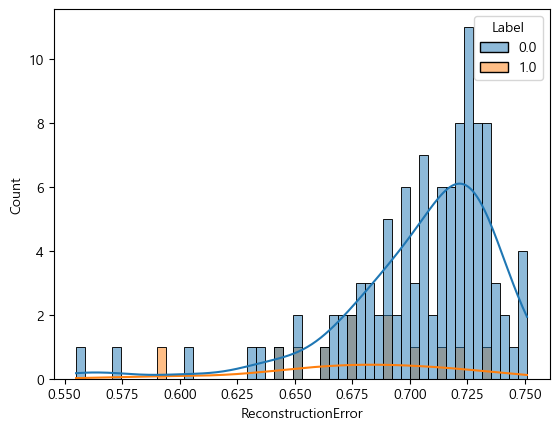

In [164]:
# 재건 에러 계산 함수
def reconstruction_error(x, p):
    return np.mean(np.abs(x - p), axis=(1, -1))

rce = reconstruction_error(X_test_sc, X_test_pred)
print(f"Modified rce shape: {rce.shape}")

# rce와 y_val을 하나의 DataFrame으로 만듭니다.
df = pd.DataFrame({'ReconstructionError': rce, 'Label': y_test})

# 히스토그램을 그립니다.
plt.figure()
sns.histplot(data=df, x='ReconstructionError', hue='Label', bins=50, kde=True)
plt.show()


정확도        : 0.3418803418803419
F1       점수 : 0.09411764705882353
recall   점수 : 0.3333333333333333
precision 점수: 0.0547945205479452
[[36 69]
 [ 8  4]]


<Figure size 640x480 with 0 Axes>

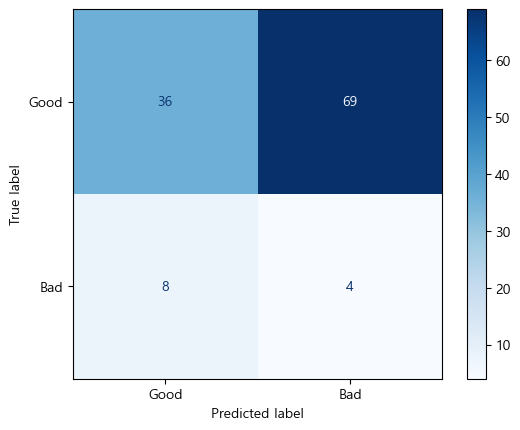

In [166]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, confusion_matrix, recall_score, precision_score

# 임계값 설정, 이 값은 문제에 따라 다르게 설정해야 할 수 있습니다.
threshold = 0.7

# 재구성 에러 계산
rce = reconstruction_error(X_test_sc, X_test_pred)

# 재구성 에러가 임계값보다 큰 경우를 'Bad'(1)로, 그렇지 않은 경우를 'Good'(0)으로 분류
p_val_bin = (rce > threshold).astype(int)

# 이제 p_val_bin과 y_val의 차원이 일치하므로, 평가 메트릭을 계산할 수 있습니다.
print('정확도        :', accuracy_score(y_test, p_val_bin))
print('F1       점수 :', f1_score(y_test, p_val_bin))
print('recall   점수 :', recall_score(y_test, p_val_bin))
print('precision 점수:', precision_score(y_test, p_val_bin))
print(confusion_matrix(y_test, p_val_bin))
plt.figure()
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, p_val_bin), display_labels=['Good', 'Bad']).plot(cmap='Blues')
plt.show()

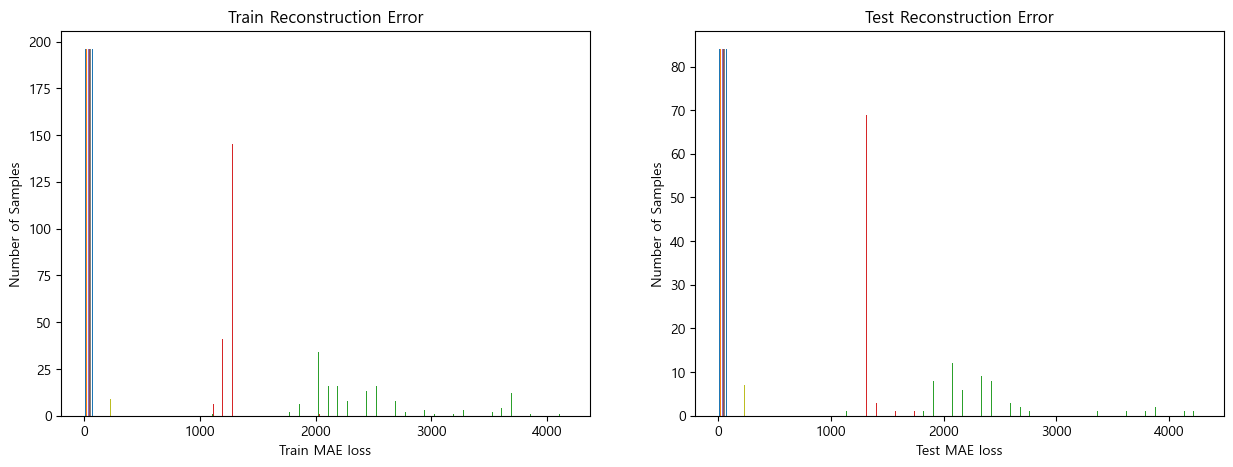

In [9]:
# 재건 오류 계산
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

# 재건 오류 시각화
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Train Reconstruction Error')
plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

plt.subplot(1, 2, 2)
plt.title('Test Reconstruction Error')
plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of Samples');

plt.show()

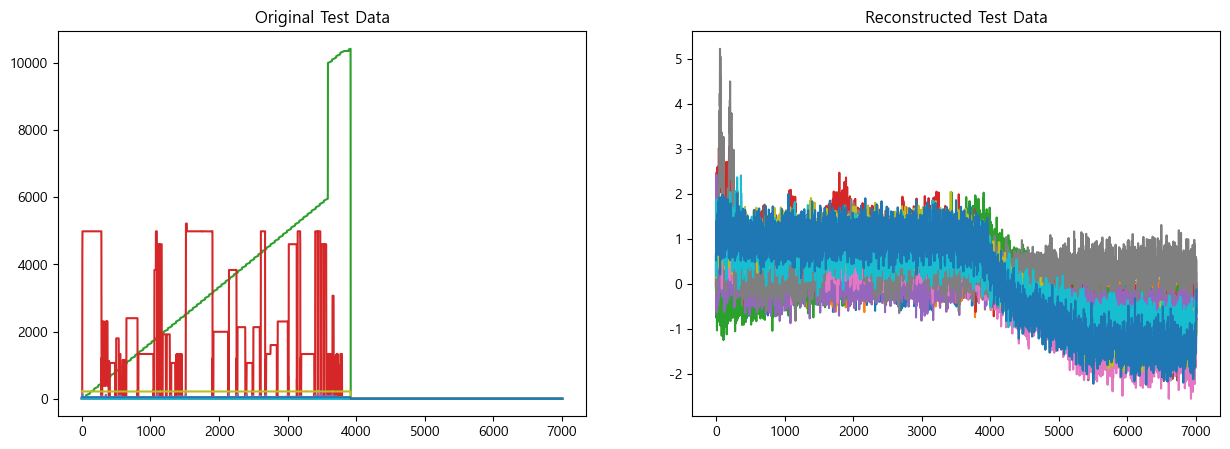

In [10]:
# 원본 데이터와 재구성된 데이터의 비교 시각화 (테스트 데이터의 첫 번째 샘플을 사용)
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Original Test Data')
plt.plot(X_test[0])

plt.subplot(1, 2, 2)
plt.title('Reconstructed Test Data')
plt.plot(X_test_pred[0])

plt.show()